# Data Exploration

## Imports

In [39]:
# for reading the database file
import sqlite3
import pandas as pd
import numpy as np
import os
import json

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Database Setup

In [40]:
# database filename
DATA_FILE = '../statsbomb/statsbomb_euro2020.db'

# double check that it's a valid filepath
os.path.exists(DATA_FILE)

True

## Querying Helper
We want to make sure that the SQLite connection closes

In [41]:
def execute_query(query:str, verbose=False):
    '''
    Executes the given query to the database file then closes the connection.

    Partially taken from https://www.geeksforgeeks.org/python/python-sqlite-connecting-to-database/, 
    but pandas has a nice way to query sqlite3 connections and return a DataFrame. We're very comfortable 
    working with pandas DataFrames.

    Parameters
    ----------
    query : str
        The SQL query for the database.

    Returns
    -------
    query_result : pandas.DataFrame
        The output of the SQL query. If the query fails, the returned table will be empty.
    '''
    try:
        # first connect to the database
        # ?mode=ro with uri=True opens the file in read-only mode; this is to prevent data corruption
        # https://stackoverflow.com/questions/10205744/opening-sqlite3-database-from-python-in-read-only-mode
        sqliteConnection = sqlite3.connect(f"file:{DATA_FILE}?mode=ro", uri=True)
        if verbose:
            print("Connection successful.")

        # Execute the query
        query_result = pd.read_sql_query(query, sqliteConnection)

        # If it succeeded, return
        return query_result
    except sqlite3.Error as error:
        # The query probably failed - throw an error and return an empty dataframe
        print(f"Error occured: {error}")
        return pd.DataFrame()
    finally:
        # Close the connection no matter what
        if sqliteConnection:
            sqliteConnection.close()
            if verbose:
                print("Connection closed.")

In [65]:
conn = sqlite3.connect(f"file:{DATA_FILE}?mode=ro", uri=True)

query = """
SELECT * 
FROM events
WHERE type = "Pass" OR type = "Carry" OR id = "fc81639c-6e60-49d3-b29a-82b2b8c5746d"
"""

df = pd.read_sql_query(query, conn)

cols = [
    # "id",
    "type",
    # "shot_outcome",
    "player",
    "location",
    "carry_end_location",
    # "pass_end_location",
    # "pass_recipient",
    # "pass_assisted_shot_id",
    # "pass_outcome",
    ]

# select ids:
'''
0 (normal pass)
30 (pass as assist)
98620 (failed assist since the shot did not score)
    id = fc81639c-6e60-49d3-b29a-82b2b8c5746d (assist failed)
54819 (carry)
'''

df = df.iloc[[
    # 0, 
    # 30, 
    # 98620, 
    54819
    ]]
# df = df.loc[df.pass_assisted_shot_id.notna()]
df[cols]

,type,player,location,carry_end_location
54819,Carry,Caglar Söyüncü,"[32.5, 28.8]","[36.2, 30.4]"


In [67]:
# passes
passes = pd.read_sql_query('select location, pass_end_location from events where type = "Pass"', conn)
# carries
carries = pd.read_sql_query('select location, carry_end_location from events where type = "Carry"', conn)
# shots
shots = pd.read_sql_query('select location from events where type = "Shot"', conn)

In [75]:
import ast
pass_starts = passes['location'].map(ast.literal_eval).tolist()
pass_ends = passes['pass_end_location'].map(ast.literal_eval).tolist()

carry_starts = carries['location'].map(ast.literal_eval).tolist()
carry_ends = carries['carry_end_location'].map(ast.literal_eval).tolist()

shot_locs = shots['location'].map(ast.literal_eval).tolist()

In [107]:
def get_grid(loc, n_rows:int=8, n_cols:int=12):
    '''
    Return the row, column for the location based on a 120x80 soccer pitch

    Parameters
    ----------
    loc : list of float
        The location to classify (x, y) typically
    n_rows : int
        The number of rows the pitch is split into (splits the 80 dimension)
    n_cols : int
        The number of columns the pitch is split into (spltis the 120 dimension)
    '''
    row = int((loc[1]  * (n_rows-1)) / 80)
    col = int((loc[0] * (n_cols-1)) / 120)

    return [row, col]

n_rows, n_cols = 8, 12

loc = pass_starts[1]
print(loc)

get_grid(loc, n_rows, n_cols)

[36.2, 30.4]


[2, 3]

In [108]:
pass_starts_grid = [get_grid(loc) for loc in pass_starts]
pass_ends_grid = [get_grid(loc) for loc in pass_ends]
carry_starts_grid = [get_grid(loc) for loc in carry_starts]
carry_ends_grid = [get_grid(loc) for loc in carry_ends]
shot_locs_grid = [get_grid(loc) for loc in shot_locs]

In [110]:
min([start[0] for start in pass_starts_grid]), min([start[1] for start in pass_starts_grid]), max([start[0] for start in pass_starts_grid]), max([start[1] for start in pass_starts_grid])

(0, 0, 7, 11)

In [120]:
# compute transitions
transition_freqs = np.zeros((8,12,8,12))
shot_freqs = np.zeros((8,12))

for i, (start) in enumerate(pass_starts_grid):
    end = pass_ends_grid[i]
    transition_freqs[start[0], start[1], end[0], end[1]] += 1

for i, start in enumerate(carry_starts_grid):
    end = carry_ends_grid[i]
    transition_freqs[start[0], start[1], end[0], end[1]] += 1

for loc in shot_locs_grid:
    shot_freqs[loc[0], loc[1]] += 1

In [124]:
# get relative frequencies
transition_rel_freqs = np.zeros((8,12,8,12))
shot_rel_freqs = np.zeros((8,12))

for i in range(8):
    for j in range(12):
        total_n = np.sum(transition_freqs[i,j,:,:]) + shot_freqs[i,j]
        if total_n == 0:
            continue
        # get relative frequency
        transition_rel_freqs[i,j,:,:] = transition_freqs[i,j,:,:] / total_n
        shot_rel_freqs[i,j] = shot_freqs[i,j] / total_n

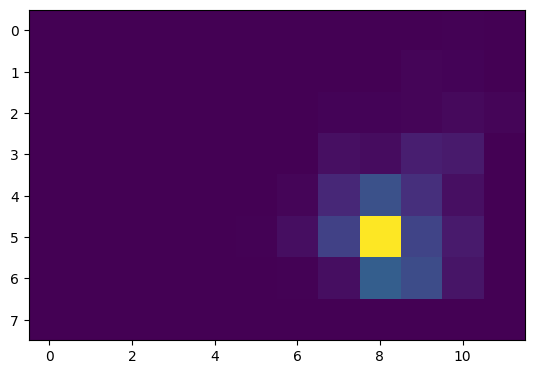

In [ ]:
# plot example
import matplotlib.pyplot as plt
row, col = 5, 8

plt.imshow(transition_rel_freqs[row,col,:,:])

plt.show()

# Stuff for the report

In [7]:
import sqlite3
import pandas as pd
import numpy as np

db_path = "../statsbomb/statsbomb_euro2020.db"

In [3]:
# connect and get events
conn = sqlite3.connect(f"file:{db_path}?mode=ro", uri=True)
events = pd.read_sql_query("select * from events", conn)
conn.close()

In [23]:
event_types = np.unique(events['type'])
event_freqs = np.zeros(len(event_types))

for i, etype in enumerate(event_types):
    event_freqs[i] = len(events.loc[events.type == etype])

# event_freqs = event_freqs / len(events)

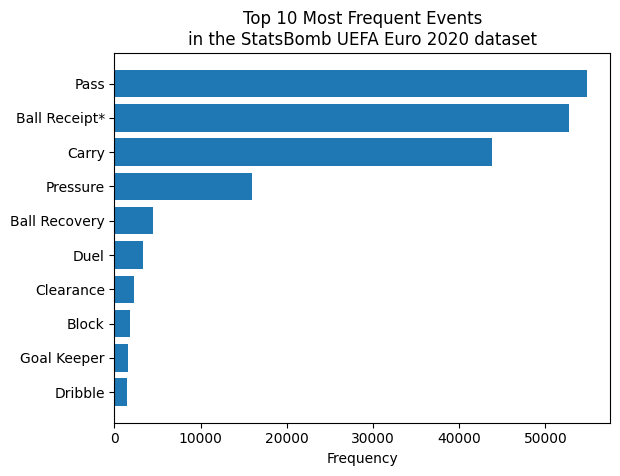

In [ ]:
import matplotlib.pyplot as plt

# sort them
ordering = np.argsort(event_freqs)

types = event_types[ordering]
freqs = event_freqs[ordering]

n = 10
types = types[-n:]
freqs = freqs[-n:]

plt.title(f"Top {n} Most Frequent Events in the\nStatsBomb UEFA Euro 2020 dataset")
plt.xlabel("Frequency")
plt.barh(types, freqs)
plt.show()

In [28]:
events[events.type == 'Ball Receipt*']

,fifty_fifty,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,...,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
1065,None,None,None,None,None,None,None,None,None,None,...,None,NaN,None,NaN,None,Turkey,909,00:00:02.789,Ball Receipt*,None
1066,None,None,None,None,None,None,None,None,None,None,...,None,NaN,None,NaN,None,Turkey,909,00:00:06.764,Ball Receipt*,1.0
1067,None,None,None,None,None,None,None,None,None,None,...,None,NaN,None,NaN,None,Italy,914,00:00:14.093,Ball Receipt*,None
1068,None,None,None,None,None,None,None,None,None,None,...,None,NaN,None,NaN,None,Italy,914,00:00:18.242,Ball Receipt*,None
1069,None,None,None,None,None,None,None,None,None,None,...,None,NaN,None,NaN,None,Italy,914,00:00:21.072,Ball Receipt*,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190570,None,None,Incomplete,None,None,None,None,None,None,None,...,None,NaN,None,NaN,None,Italy,914,00:17:09.792,Ball Receipt*,None
190571,None,None,None,None,None,None,None,None,None,None,...,None,NaN,None,NaN,None,England,768,00:17:46.915,Ball Receipt*,None
190572,None,None,Incomplete,None,None,None,None,None,None,None,...,None,NaN,None,NaN,None,Italy,914,00:17:50.956,Ball Receipt*,None
190573,None,None,None,None,None,None,None,None,None,None,...,None,NaN,None,NaN,None,England,768,00:18:00.492,Ball Receipt*,None


# Tests

In [37]:
# First, test that the database is in read-only mode.
write_query = '''
CREATE TABLE custom_table(
    id INT PRIMARY KEY
);
'''

try:
    query_result = execute_query(write_query)
    print("The database is not in read-only mode...")
except Exception as e:
    print(f"The query failed with exception\n\n{e}")

The query failed with exception

Execution failed on sql '
CREATE TABLE custom_table(
    id INT PRIMARY KEY
);
': attempt to write a readonly database


In [38]:
# A bit more involved test that might inform us a bit
# Now I'm curious about how many games each team played
query = '''
SELECT *
FROM matches;
'''

query_result = execute_query(query)

# everything after the query is just Python pandas stuff
# get all the teams in one list
teams = query_result.home_team.tolist() + query_result.away_team.tolist()
# make a dictionary with the game counts for each team
game_counts = {}
for team in teams:
    if team in game_counts.keys():
        game_counts[team] += 1
    else:
        game_counts[team] = 1

print(json.dumps(game_counts, indent=3))

{
   "Switzerland": 5,
   "Russia": 3,
   "Italy": 7,
   "Sweden": 4,
   "Portugal": 4,
   "Turkey": 3,
   "Spain": 6,
   "Croatia": 4,
   "Austria": 4,
   "Czech Republic": 5,
   "Ukraine": 5,
   "North Macedonia": 3,
   "England": 7,
   "Belgium": 5,
   "Germany": 4,
   "Finland": 3,
   "Hungary": 3,
   "Denmark": 6,
   "Wales": 4,
   "Netherlands": 4,
   "France": 4,
   "Poland": 3,
   "Scotland": 3,
   "Slovakia": 3
}


No team has more than 7 games. I'm also kind of curious about when these games take place relative to one another.

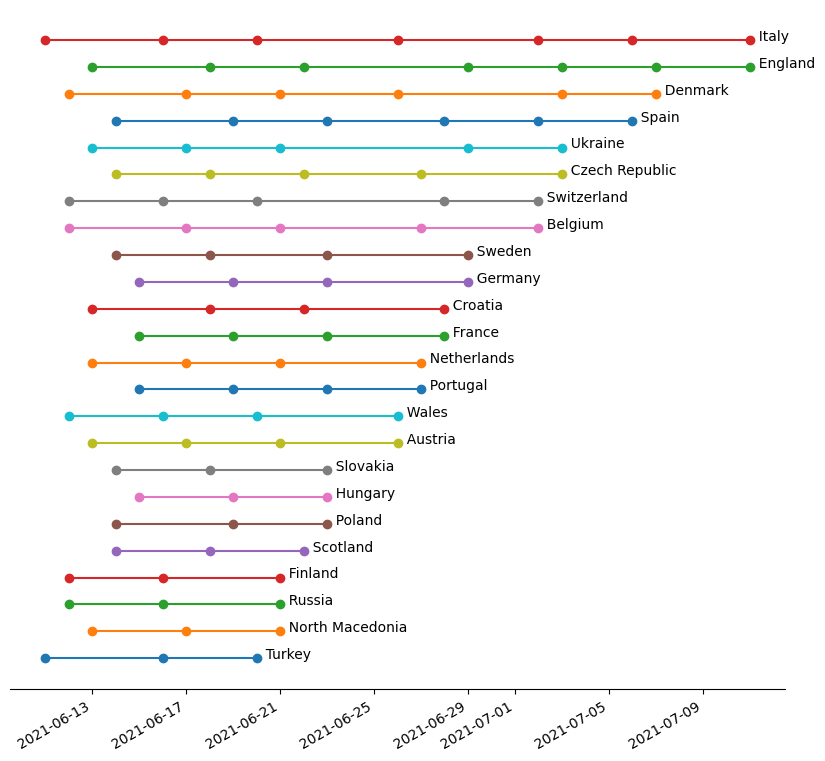

In [115]:
# get team order based on the last game played
last_dates = []

for team in game_counts.keys():
    curr = query_result.loc[(query_result.home_team==team) | (query_result.away_team==team), :]
    last_dates += [max(curr.match_date)]

ordering = np.argsort(last_dates)
teams = [team for team in game_counts.keys()]
teams = [teams[i] for i in ordering]

# get the dates for each game for each team
y_diff = 1
y = 0

fig, ax = plt.subplots(figsize=(10,10))

for team in teams:
    team_query = f"""
SELECT *
FROM matches
WHERE home_team='{team}' OR away_team='{team}'
ORDER BY match_date ASC;
"""
    relevant_games = execute_query(team_query)

    # update height of this line then plot it
    y += y_diff
    ax.plot(pd.to_datetime(relevant_games.match_date), [y]*len(relevant_games), '-o')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    # print(f"Team: {team}")
    # print(f"Dates: {relevant_games.match_date.tolist()}")
    # print(f"Chosen date: {relevant_games.match_date.tolist()[-1]}")
    # label the line
    ax.annotate(f"  {team}", (pd.to_datetime(relevant_games.match_date).iloc[-1], y))

# remove y axis stuff
ax.set(yticklabels=[])
ax.tick_params(left=False)

# remove left, top and right spines
for pos in ['left', 'top', 'right']:
    ax.spines[pos].set_visible(False)
fig.autofmt_xdate()
plt.show()

In [107]:
last_dates = []

for team in game_counts.keys():
    curr = query_result.loc[(query_result.home_team==team) | (query_result.away_team==team), :]
    last_dates += [max(curr.match_date)]

np.argsort(last_dates)

array([ 5, 11,  1, 15, 22, 21, 16, 23,  8, 18,  4, 19, 20,  7, 14,  3, 13,
        0,  9, 10,  6, 17, 12,  2])